<a href="https://colab.research.google.com/github/alisharifi2000/PSO_TSP/blob/main/PSO_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencage
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp36-cp36m-linux_x86_64.whl size=121757478 sha256=25e6d32bf661b70aa2fa2f9c798d366883082e39f60afd5a17454a65e1e0ca4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-mkv9szua/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [2]:
import numpy as np
import pandas as pd
from geopy import distance
from opencage.geocoder import OpenCageGeocode
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import random
from itertools import chain
import time
from operator import attrgetter
import random
import sys
import copy

In [3]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [4]:
def get_location(city,country):
    key = '94bbd66c2b5743b4b4acf04d59f6559c'
    geocoder = OpenCageGeocode(key)
    query = city+' , '+country  
    results = geocoder.geocode(query)
    lat = results[0]['geometry']['lat']
    lng = results[0]['geometry']['lng']
    
    return [lat,lng]

In [5]:
def get_city_country(cities):
  city = [c.split(',')[0] for c in cities.split('\n')]
  print(city)
  country = [c.split(',')[1] for c in cities.split('\n')]
  print(country)

  return [city,country]

In [6]:
def make_dataset(city,country):
  # make dataframe 
  dict = {'City':city,'Country':country}
  dataset = pd.DataFrame(dict)
  dataset['lat'] = 0
  dataset['lng'] = 0
  dataset.index = dataset['City']

  return dataset

In [7]:
def fill_lat_lng(dataset):
  for c in list(dataset.index):
      city_name = dataset.loc[c,'City']
      country_name = dataset.loc[c,'Country']
      [lat,lng] = get_location(city_name,country_name)
      dataset.loc[c,'lat'] = lat
      dataset.loc[c,'lng'] = lng
    
  return dataset

In [8]:
def draw_cities_in_map(dataset):
  fig = plt.figure(figsize=(15, 10), edgecolor='w')
  m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
  m.scatter(dataset['lng'], dataset['lat'], latlon=True,
          c = 'black', s = 5)
  draw_map(m)

In [9]:
# class that represents a graph
class Graph:

	def __init__(self, amount_vertices):
		self.edges = {} # dictionary of edges
		self.vertices = set() # set of vertices
		self.amount_vertices = amount_vertices # amount of vertices


	# adds a edge linking "src" in "dest" with a "cost"
	def addEdge(self, src, dest, cost = 0):
		# checks if the edge already exists
		if not self.existsEdge(src, dest):
			self.edges[(src, dest)] = cost
			self.vertices.add(src)
			self.vertices.add(dest)


	# checks if exists a edge linking "src" in "dest"
	def existsEdge(self, src, dest):
		return (True if (src, dest) in self.edges else False)


	# shows all the links of the graph
	def showGraph(self):
		print('Showing the graph:\n')
		for edge in self.edges:
			print('%d linked in %d with cost %d' % (edge[0], edge[1], self.edges[edge]))

	# returns total cost of the path
	def getCostPath(self, path):
		
		total_cost = 0
		for i in range(self.amount_vertices - 1):
			total_cost += self.edges[(path[i], path[i+1])]

		# add cost of the last edge
		total_cost += self.edges[(path[self.amount_vertices - 1], path[0])]
		return total_cost


	# gets random unique paths - returns a list of lists of paths
	def getRandomPaths(self, max_size):

		random_paths, list_vertices = [], list(self.vertices)

		initial_vertice = random.choice(list_vertices)
		if initial_vertice not in list_vertices:
			print('Error: initial vertice %d not exists!' % initial_vertice)
			sys.exit(1)

		list_vertices.remove(initial_vertice)
		list_vertices.insert(0, initial_vertice)

		for i in range(max_size):
			list_temp = list_vertices[1:]
			random.shuffle(list_temp)
			list_temp.insert(0, initial_vertice)

			if list_temp not in random_paths:
				random_paths.append(list_temp)

		return random_paths

In [10]:
# class that represents a particle
class Particle:

	def __init__(self, solution, cost):

		# current solution
		self.solution = solution

		# best solution (fitness) it has achieved so far
		self.pbest = solution

		# set costs
		self.cost_current_solution = cost
		self.cost_pbest_solution = cost

		# velocity of a particle is a sequence of 4-tuple
		# (1, 2, 1, 'beta') means SO(1,2), prabability 1 and compares with "beta"
		self.velocity = []

	# set pbest
	def setPBest(self, new_pbest):
		self.pbest = new_pbest

	# returns the pbest
	def getPBest(self):
		return self.pbest

	# set the new velocity (sequence of swap operators)
	def setVelocity(self, new_velocity):
		self.velocity = new_velocity

	# returns the velocity (sequence of swap operators)
	def getVelocity(self):
		return self.velocity

	# set solution
	def setCurrentSolution(self, solution):
		self.solution = solution

	# gets solution
	def getCurrentSolution(self):
		return self.solution

	# set cost pbest solution
	def setCostPBest(self, cost):
		self.cost_pbest_solution = cost

	# gets cost pbest solution
	def getCostPBest(self):
		return self.cost_pbest_solution

	# set cost current solution
	def setCostCurrentSolution(self, cost):
		self.cost_current_solution = cost

	# gets cost current solution
	def getCostCurrentSolution(self):
		return self.cost_current_solution

	# removes all elements of the list velocity
	def clearVelocity(self):
		del self.velocity[:]

In [31]:
# PSO algorithm
class PSO:
    def __init__(self, graph, iterations = 100, size_population = 50, beta=1, alpha=1):
        self.graph = graph # the graph
        self.iterations = iterations # max of iterations
        self.size_population = size_population # size population
        self.particles = [] # list of particles
        self.beta = beta # the probability that all swap operators in swap sequence (gbest - x(t-1))
        self.alpha = alpha # the probability that all swap operators in swap sequence (pbest - x(t-1))
        self.history = {}

        # initialized with a group of random particles (solutions)
        solutions = self.graph.getRandomPaths(self.size_population)

        # checks if exists any solution
        if not solutions:
            print('Initial population empty! Try run the algorithm again...')
            sys.exit(1)

        # creates the particles and initialization of swap sequences in all the particles
        for solution in solutions:
            # creates a new particle
            particle = Particle(solution=solution, cost=graph.getCostPath(solution))
            # add the particle
            self.particles.append(particle)

        # updates "size_population"
        self.size_population = len(self.particles)


    # set gbest (best particle of the population)
    def setGBest(self, new_gbest):
        self.gbest = new_gbest

	# returns gbest (best particle of the population)
    def getGBest(self):
        return self.gbest

    def fill_coverage(self):
        coverages = []
        for iter in range(self.iterations):
            sum = 0
            count = 0
            for particle in self.particles:
                sum = sum + particle.getCostPBest()
                count = count + 1
                
            coverages.append(int(sum/count))
        self.history['history'] = coverages

	# shows the info of the particles
    def showsParticles(self):

        print('Showing particles...\n')
        for particle in self.particles:
            print('pbest: %s\t|\tcost pbest: %d\t|\tcurrent solution: %s\t|\tcost current solution: %d' \
                % (str(particle.getPBest()), particle.getCostPBest(), str(particle.getCurrentSolution()),
                    particle.getCostCurrentSolution()))
        print('')


    def run(self):
        # for each time step (iteration)
        for t in range(self.iterations):

        # updates gbest (best particle of the population)
            self.gbest = min(self.particles, key=attrgetter('cost_pbest_solution'))

            # for each particle in the swarm
            for particle in self.particles:

                particle.clearVelocity() # cleans the speed of the particle
                temp_velocity = []
                solution_gbest = copy.copy(self.gbest.getPBest()) # gets solution of the gbest
                solution_pbest = particle.getPBest()[:] # copy of the pbest solution
                solution_particle = particle.getCurrentSolution()[:] # gets copy of the current solution of the particle

				# generates all swap operators to calculate (pbest - x(t-1))
                for i in range(self.graph.amount_vertices):
                    if solution_particle[i] != solution_pbest[i]:
                        # generates swap operator
                        swap_operator = (i, solution_pbest.index(solution_particle[i]), self.alpha)

                        # append swap operator in the list of velocity
                        temp_velocity.append(swap_operator)

                        # makes the swap
                        aux = solution_pbest[swap_operator[0]]
                        solution_pbest[swap_operator[0]] = solution_pbest[swap_operator[1]]
                        solution_pbest[swap_operator[1]] = aux

                # generates all swap operators to calculate (gbest - x(t-1))
                for i in range(self.graph.amount_vertices):
                    if solution_particle[i] != solution_gbest[i]:
                        # generates swap operator
                        swap_operator = (i, solution_gbest.index(solution_particle[i]), self.beta)

                        # append swap operator in the list of velocity
                        temp_velocity.append(swap_operator)

                        # makes the swap
                        aux = solution_gbest[swap_operator[0]]
                        solution_gbest[swap_operator[0]] = solution_gbest[swap_operator[1]]
                        solution_gbest[swap_operator[1]] = aux

				
                # updates velocity
                particle.setVelocity(temp_velocity)

                # generates new solution for particle
                for swap_operator in temp_velocity:
                    if random.random() <= swap_operator[2]:
                        # makes the swap
                        aux = solution_particle[swap_operator[0]]
                        solution_particle[swap_operator[0]] = solution_particle[swap_operator[1]]
                        solution_particle[swap_operator[1]] = aux
				
                # updates the current solution
                particle.setCurrentSolution(solution_particle)
                # gets cost of the current solution
                cost_current_solution = self.graph.getCostPath(solution_particle)
                # updates the cost of the current solution
                particle.setCostCurrentSolution(cost_current_solution)

                # checks if current solution is pbest solution
                if cost_current_solution < particle.getCostPBest():
                    particle.setPBest(solution_particle)
                    particle.setCostPBest(cost_current_solution)

In [32]:
def make_TSP_graph(dataset):
    graph = Graph(amount_vertices=len(dataset))

    for i in range(len(dataset)):
        for j in range(len(dataset)):
            source = (dataset.iloc[i]['lat'],dataset.iloc[i]['lng'])
            dist = (dataset.iloc[j]['lat'],dataset.iloc[j]['lng'])

            if i!= j:
                cost = int(distance.distance(source,dist).km)
                graph.addEdge(i, j, cost)

    return graph

In [33]:
def make_cities_dict(dataset):
    dict = {}
    for i in range(len(dataset)):
        dict[i] = dataset.iloc[i]['City']

    return dict

In [34]:
def plot_pso_convergence(costs,min_cost):
    x = range(len(costs))
    plt.figure(figsize=(10, 5), edgecolor='w')
    plt.title("ACO Convergence")
    plt.xlabel('Iteration')
    plt.ylabel('cost (KM)')
    plt.text(x[len(x) // 2], costs[0], 'min cost: {} KM'.format(min_cost), ha='center', va='center')
    plt.plot(x, costs, '-')

In [35]:
def show_best_path(path,min_cost,dict):
    print('PSO completed')
    print(f'Minimum travelling cost {min_cost} KM')
    print('-----------------')
    print('Best Path : ')
    print('-----------------')
    for i in range(len(path)):
        print(f"{i+1}. {dict[path[i]]}")

In [36]:
def plot_route(dataset,path,dict):
    plt.figure(figsize=(15, 10), edgecolor='w')
    plt.title("Best Route (start point is blue )")
    m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
    
    lat = []
    lon = []

    for i in range(len(path)):
      city_name = dict[path[i]]
      lat.append(dataset.loc[city_name,'lat'])
      lon.append(dataset.loc[city_name,'lng'])

    x, y = m(lon, lat)

    
    m.plot(x, y, '--', markersize=4, linewidth=1 , c = 'red')

    m.scatter(x, y, latlon=True,
          c = 'black', s = 8)
    
    m.scatter(lon[0], lat[0], latlon=True,
          c = 'blue', s = 15 , marker = 'x')
    
    draw_map(m)

# 10 cities

In [37]:
# 10 cities
cities = """New York,USA
Berlin,Germany
Chicago,USA
London,UK
Paris,France
Tehran,Iran
Istanbul,Turkey
San Francisco,USA
Vienna,Austria
Boston,USA"""

In [38]:
result = get_city_country(cities)
dataset = make_dataset(result[0],result[1])
dataset = fill_lat_lng(dataset)
cities_dict = make_cities_dict(dataset)
dataset.head()

['New York', 'Berlin', 'Chicago', 'London', 'Paris', 'Tehran', 'Istanbul', 'San Francisco', 'Vienna', 'Boston']
['USA', 'Germany', 'USA', 'UK', 'France', 'Iran', 'Turkey', 'USA', 'Austria', 'USA']


,City,Country,lat,lng
City,,,,
New York,New York,USA,40.712728,-74.006015
Berlin,Berlin,Germany,52.517037,13.388860
Chicago,Chicago,USA,41.875562,-87.624421
London,London,UK,51.507322,-0.127647
Paris,Paris,France,48.856697,2.351462


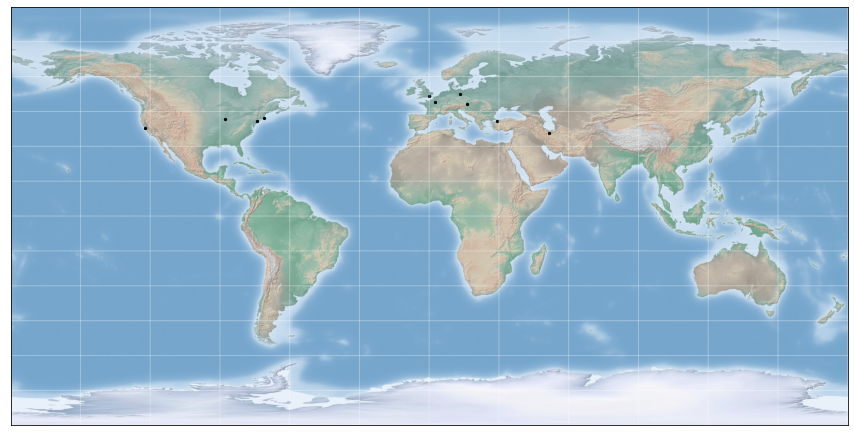

In [39]:
draw_cities_in_map(dataset)

# defult parameters

PSO completed
Minimum travelling cost 26629 KM
-----------------
Best Path : 
-----------------
1. Istanbul
2. Vienna
3. Berlin
4. Paris
5. London
6. Boston
7. New York
8. Chicago
9. San Francisco
10. Tehran


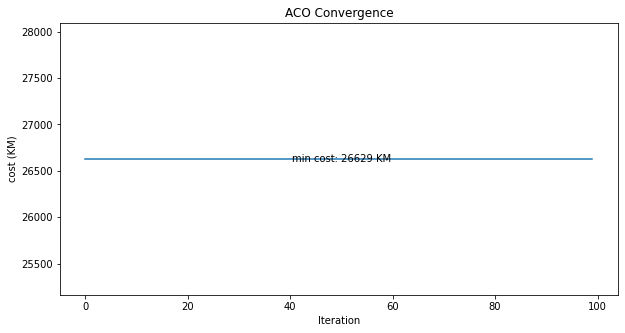

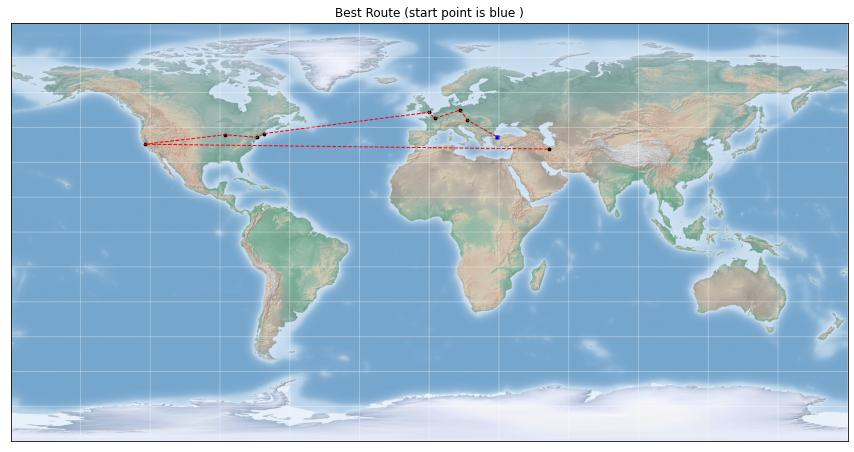

In [40]:
'''
iterations = 100
size_population = 50
beta=1
alpha=1
'''

graph = make_TSP_graph(dataset)

# creates a PSO instance
pso = PSO(graph)
pso.run() # runs the PSO algorithm
pso.fill_coverage()
min_cost = pso.getGBest().getCostPBest()
best_history = pso.history['history']
best_path = pso.getGBest().getPBest()

for i in range(50):
    pso = PSO(graph)
    pso.run() # runs the PSO algorithm
    pso.fill_coverage()

    if pso.getGBest().getCostPBest() < min_cost:
        min_cost = pso.getGBest().getCostPBest()
        best_history = pso.history['history']
        best_path = pso.getGBest().getPBest()

show_best_path(best_path,min_cost,cities_dict)
plot_pso_convergence(best_history,min_cost)
plot_route(dataset,best_path,cities_dict)

# 30 Cities

In [41]:
# 30 cities
cities = """New York,USA
Munich,Germany
Warsaw,Poland
Stockholm,Sweden
Barcelona,Spain
Helsinki,Finland
Tallinn,Estonia
Amsterdam,Netherlands
Prague,the Czech Republic
Madrid,Spain
Rome,Italy
Budapest,Hungary
Lisbon,Portugal
Copenhagen,Denmark
Dublin,Republic of Ireland
Athens,Greece
Berlin,Germany
Chicago,USA
London,UK
Paris,France
Tehran,Iran
Oslo,Norway
Istanbul,Turkey
Bucharest,Romania
Shiraz,Iran
Mashhad,Iran
Qom,Iran
San Francisco,USA
Vienna,Austria
Boston,USA"""

In [42]:
result = get_city_country(cities)
dataset = make_dataset(result[0],result[1])
dataset = fill_lat_lng(dataset)
cities_dict = make_cities_dict(dataset)
dataset.head()

['New York', 'Munich', 'Warsaw', 'Stockholm', 'Barcelona', 'Helsinki', 'Tallinn', 'Amsterdam', 'Prague', 'Madrid', 'Rome', 'Budapest', 'Lisbon', 'Copenhagen', 'Dublin', 'Athens', 'Berlin', 'Chicago', 'London', 'Paris', 'Tehran', 'Oslo', 'Istanbul', 'Bucharest', 'Shiraz', 'Mashhad', 'Qom', 'San Francisco', 'Vienna', 'Boston']
['USA', 'Germany', 'Poland', 'Sweden', 'Spain', 'Finland', 'Estonia', 'Netherlands', 'the Czech Republic', 'Spain', 'Italy', 'Hungary', 'Portugal', 'Denmark', 'Republic of Ireland', 'Greece', 'Germany', 'USA', 'UK', 'France', 'Iran', 'Norway', 'Turkey', 'Romania', 'Iran', 'Iran', 'Iran', 'USA', 'Austria', 'USA']


,City,Country,lat,lng
City,,,,
New York,New York,USA,40.712728,-74.006015
Munich,Munich,Germany,48.137108,11.575382
Warsaw,Warsaw,Poland,52.231958,21.006725
Stockholm,Stockholm,Sweden,59.325117,18.071093
Barcelona,Barcelona,Spain,41.382894,2.177432


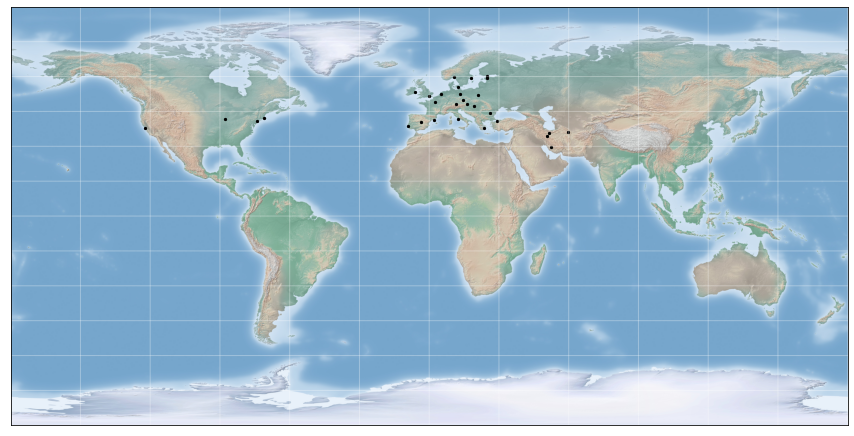

In [43]:
draw_cities_in_map(dataset)

## defult paramters

PSO completed
Minimum travelling cost 51996 KM
-----------------
Best Path : 
-----------------
1. New York
2. Boston
3. Lisbon
4. Madrid
5. Barcelona
6. Stockholm
7. Qom
8. Rome
9. Copenhagen
10. Tallinn
11. Budapest
12. Shiraz
13. Mashhad
14. Tehran
15. Warsaw
16. Istanbul
17. Athens
18. Bucharest
19. Helsinki
20. Berlin
21. Paris
22. Munich
23. Amsterdam
24. Prague
25. Vienna
26. London
27. Dublin
28. Oslo
29. San Francisco
30. Chicago


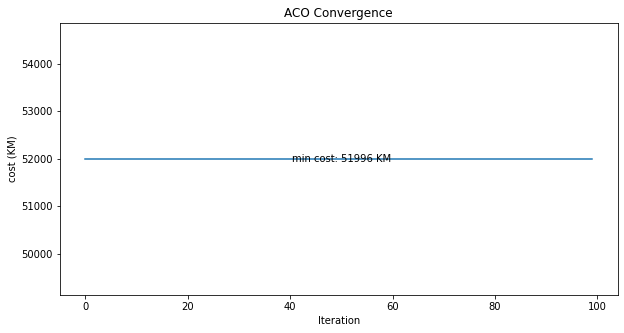

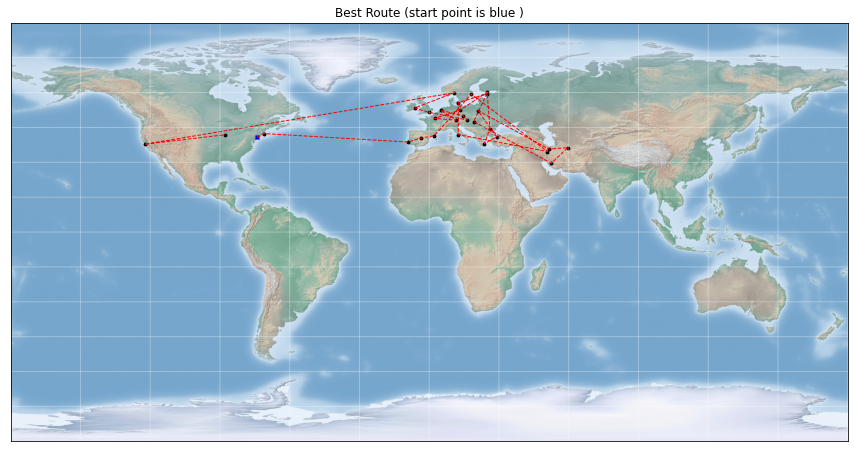

In [44]:
'''
iterations = 100
size_population = 50
beta=1
alpha=1
'''

graph = make_TSP_graph(dataset)

# creates a PSO instance
pso = PSO(graph)
pso.run() # runs the PSO algorithm
pso.fill_coverage()
min_cost = pso.getGBest().getCostPBest()
best_history = pso.history['history']
best_path = pso.getGBest().getPBest()

for i in range(50):
    pso = PSO(graph)
    pso.run() # runs the PSO algorithm
    pso.fill_coverage()

    if pso.getGBest().getCostPBest() < min_cost:
        min_cost = pso.getGBest().getCostPBest()
        best_history = pso.history['history']
        best_path = pso.getGBest().getPBest()

show_best_path(best_path,min_cost,cities_dict)
plot_pso_convergence(best_history,min_cost)
plot_route(dataset,best_path,cities_dict)

## pop size = 100

PSO completed
Minimum travelling cost 48334 KM
-----------------
Best Path : 
-----------------
1. San Francisco
2. Chicago
3. Boston
4. New York
5. Munich
6. Vienna
7. Berlin
8. Prague
9. Helsinki
10. Tallinn
11. Mashhad
12. Shiraz
13. Tehran
14. Qom
15. Paris
16. London
17. Budapest
18. Oslo
19. Warsaw
20. Stockholm
21. Athens
22. Bucharest
23. Istanbul
24. Rome
25. Amsterdam
26. Copenhagen
27. Barcelona
28. Lisbon
29. Madrid
30. Dublin


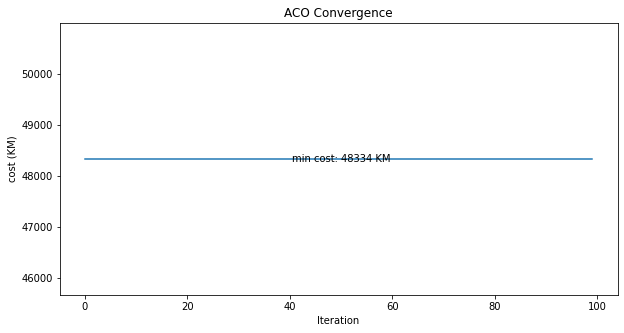

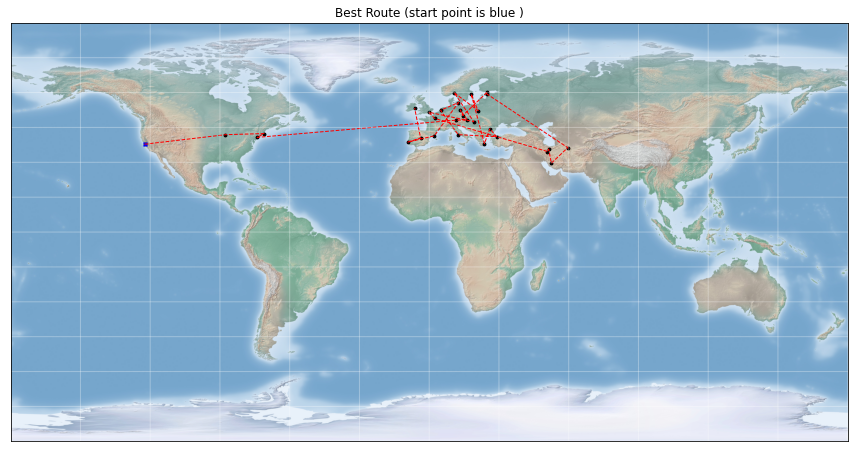

In [45]:
'''
iterations = 100
size_population = 50
beta=1
alpha=1
'''

graph = make_TSP_graph(dataset)

# creates a PSO instance
pso = PSO(graph,size_population = 100)
pso.run() # runs the PSO algorithm
pso.fill_coverage()
min_cost = pso.getGBest().getCostPBest()
best_history = pso.history['history']
best_path = pso.getGBest().getPBest()

for i in range(50):
    pso = PSO(graph,size_population = 100)
    pso.run() # runs the PSO algorithm
    pso.fill_coverage()

    if pso.getGBest().getCostPBest() < min_cost:
        min_cost = pso.getGBest().getCostPBest()
        best_history = pso.history['history']
        best_path = pso.getGBest().getPBest()

show_best_path(best_path,min_cost,cities_dict)
plot_pso_convergence(best_history,min_cost)
plot_route(dataset,best_path,cities_dict)

## pop size = 25

PSO completed
Minimum travelling cost 55520 KM
-----------------
Best Path : 
-----------------
1. Munich
2. Copenhagen
3. Madrid
4. Boston
5. San Francisco
6. Chicago
7. New York
8. Berlin
9. London
10. Bucharest
11. Rome
12. Budapest
13. Shiraz
14. Warsaw
15. Stockholm
16. Tallinn
17. Amsterdam
18. Oslo
19. Helsinki
20. Mashhad
21. Tehran
22. Qom
23. Istanbul
24. Athens
25. Prague
26. Vienna
27. Lisbon
28. Dublin
29. Barcelona
30. Paris


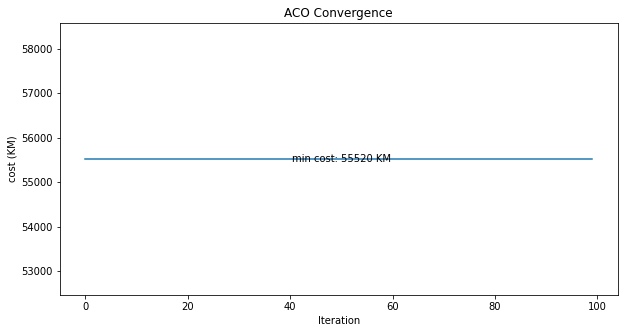

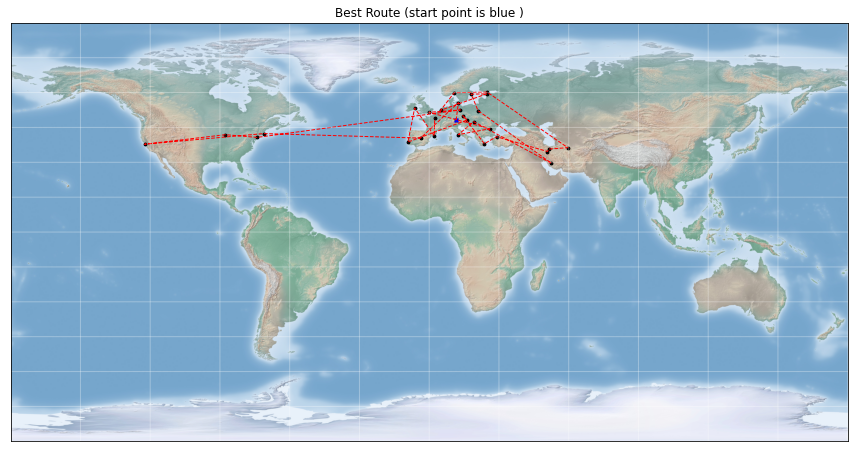

In [46]:
'''
iterations = 100
size_population = 25
beta=1
alpha=1
'''

graph = make_TSP_graph(dataset)

# creates a PSO instance
pso = PSO(graph,size_population = 25)
pso.run() # runs the PSO algorithm
pso.fill_coverage()
min_cost = pso.getGBest().getCostPBest()
best_history = pso.history['history']
best_path = pso.getGBest().getPBest()

for i in range(50):
    pso = PSO(graph,size_population = 25)
    pso.run() # runs the PSO algorithm
    pso.fill_coverage()

    if pso.getGBest().getCostPBest() < min_cost:
        min_cost = pso.getGBest().getCostPBest()
        best_history = pso.history['history']
        best_path = pso.getGBest().getPBest()

show_best_path(best_path,min_cost,cities_dict)
plot_pso_convergence(best_history,min_cost)
plot_route(dataset,best_path,cities_dict)